In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")

In [2]:
import time
import os
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from collections import defaultdict
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [21]:
from train_edm import create_model, edm_sampler, EDM
# from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch, compute_rule_statistics

In [4]:
import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


### Load in DiT model

In [5]:
DiT_configs = {
    # "DiT_XL_2": {"depth": 28, "hidden_size": 1152, "patch_size": 2, "num_heads": 16},
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    # "DiT_XL_4": {"depth": 28, "hidden_size": 1152, "patch_size": 4, "num_heads": 16},
    # "DiT_XL_8": {"depth": 28, "hidden_size": 1152, "patch_size": 8, "num_heads": 16},
    # "DiT_L_2": {"depth": 24, "hidden_size": 1024, "patch_size": 2, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    # "DiT_L_4": {"depth": 24, "hidden_size": 1024, "patch_size": 4, "num_heads": 16},
    # "DiT_L_8": {"depth": 24, "hidden_size": 1024, "patch_size": 8, "num_heads": 16},
    # "DiT_B_2": {"depth": 12, "hidden_size": 768, "patch_size": 2, "num_heads": 12},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    # "DiT_B_4": {"depth": 12, "hidden_size": 768, "patch_size": 4, "num_heads": 12},
    # "DiT_B_8": {"depth": 12, "hidden_size": 768, "patch_size": 8, "num_heads": 12},
    # "DiT_S_2": {"depth": 12, "hidden_size": 384, "patch_size": 2, "num_heads": 6},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
    # "DiT_S_4": {"depth": 12, "hidden_size": 384, "patch_size": 4, "num_heads": 6},
    # "DiT_S_8": {"depth": 12, "hidden_size": 384, "patch_size": 8, "num_heads": 6},
}

In [6]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


In [7]:
from diffusion import create_diffusion
from models import DiT

device = "cuda"
diffusion_eval = create_diffusion(timestep_respacing="ddim200")  # default: ddim100

In [8]:
class_dropout_prob = 1.0
num_classes = 0
model_cfg = DiT_configs["DiT_S_1"]
model_DiT = DiT(input_size=9,
            in_channels=3, **model_cfg,
            mlp_ratio=4.0,
            class_dropout_prob=class_dropout_prob,
            num_classes=num_classes,
            learn_sigma=True,)

In [9]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")

ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_DiT.load_state_dict(state_dict["model"])
model_DiT.to("cuda").eval();

In [10]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")

In [11]:
diffusion_train = create_diffusion(timestep_respacing="")

In [12]:
diffusion_train.timestep_map

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


### Test run and rule inference

In [22]:
diffusion_eval = create_diffusion(timestep_respacing="ddim100")  # default: ddim100
y = th.zeros(2048, dtype=torch.int, device="cuda")
model_kwargs = dict(y=y)
with th.no_grad():
    samples = diffusion_eval.ddim_sample_loop(model_DiT, shape=(2048, 3, 9, 9), clip_denoised=False, device="cuda", model_kwargs=model_kwargs, progress=True)
samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

C3: 1138/2048 (0.56), C3 + C2: 1466/2048 (0.72), AnyValid: 4569/6144 (0.74)


In [18]:
print(f"C3: {C3_count}/{total} ({C3_count/total:.2f}), C3 + C2: {C3_count + C2_count}/{total} ({(C3_count + C2_count)/total:.2f}), AnyValid: {anyvalid_count}/{total*3} ({anyvalid_count/total/3:.2f})") 

C3: 1181/2048 (0.58), C3 + C2: 1503/2048 (0.73), AnyValid: 4678/6144 (0.76)


### Load training dataset

In [13]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)

In [14]:
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

In [15]:
print(train_sample_img[0,0])

tensor([[[ 5,  5,  5,  5,  5, -1,  5, -1,  5],
         [ 5,  5,  5, -1, -1,  5,  5,  5,  5],
         [ 5,  5,  5,  5, -1, -1, -1,  5,  5],
         [-1,  6,  6,  6, -1, -1,  6,  6,  6],
         [-1, -1, -1, -1,  6,  6,  6,  6,  6],
         [-1,  6,  6,  6,  6, -1, -1,  6,  6],
         [ 2, -1,  2,  2,  2,  2, -1, -1,  2],
         [ 2,  2, -1,  2, -1, -1, -1, -1, -1],
         [ 2,  2,  2, -1,  2,  2,  2,  2, -1]],

        [[ 4,  4,  4,  2,  2, -1,  9, -1,  9],
         [ 4,  4,  4, -1, -1,  2,  9,  9,  9],
         [ 4,  4,  4,  2, -1, -1, -1,  9,  9],
         [-1,  5,  1,  5, -1, -1,  7,  1,  5],
         [-1, -1, -1, -1,  0,  1,  7,  4,  0],
         [-1,  3,  1,  8,  2, -1, -1,  7,  6],
         [ 5, -1,  5,  3,  3,  3, -1, -1,  6],
         [ 5,  5, -1,  3, -1, -1, -1, -1, -1],
         [ 5,  5,  5, -1,  3,  3,  6,  6, -1]],

        [[ 4,  8,  4,  5,  0, -1,  6, -1,  4],
         [ 0,  5,  4, -1, -1,  1,  2,  5,  8],
         [ 7,  3,  1,  2, -1, -1, -1,  8,  2],
         

In [16]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


### Utils to train a linear probe

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


# Define the training loop
def train_model(model, train_loader, num_epochs, learning_rate, print_every=50,
                eval_every=500, eval_func=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_record = []
    test_record = []
    for epoch in range(num_epochs):
        acc_total = 0
        cnt_total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc_cnt = (outputs.argmax(dim=1) == labels).sum().item()
            acc_total += acc_cnt
            cnt_total += len(labels)
        accuracy = acc_total / cnt_total
        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
        train_record.append((epoch, loss.item(), accuracy))
        if ((epoch + 1) % eval_every == 0 or epoch == num_epochs - 1) and eval_func is not None:
            test_acc, _ = eval_func(model)
            test_record.append((epoch, test_acc))
    train_record = pd.DataFrame(train_record, columns=["epoch", "loss", "accuracy"])
    test_record = pd.DataFrame(test_record, columns=["epoch", "accuracy"])
    return train_record, test_record


def test_model(model, test_loader):
    acc_total = 0
    cnt_total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        with th.no_grad():
            outputs = model(inputs)
        pred_cls = outputs.argmax(dim=1)
        acc_cnt = (pred_cls == labels).sum().item()
        acc_total += acc_cnt
        cnt_total += len(labels)
    accuracy = acc_total / cnt_total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, pred_cls


def fit_SGD_linear_classifier(train_X, train_y, test_X=None, test_y=None, 
                              num_classes=40, 
                              batch_size=1024, num_epochs=100, 
                              learning_rate = 0.001, print_every=100, eval_every=500,):
    # Define the linear classifier model
    input_size = train_X.shape[1]
    model = LinearClassifier(input_size, num_classes).to("cuda")
    if batch_size is None:
        feat_loader = [(train_X.to("cuda"), train_y.to("cuda"))]
    else:
        feat_dataset = TensorDataset(train_X.to("cuda"), train_y.to("cuda")) # .to("cuda")
        feat_loader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True,
                             drop_last=True) # pin_memory=True, num_workers=
    
    if test_X is not None and test_y is not None:
        if batch_size is None:
            test_feat_loader = [(test_X.to("cuda"), test_y.to("cuda"))]
        else:
            test_dataset = TensorDataset(test_X.to("cuda"), test_y.to("cuda")) # .to("cuda")
            test_feat_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Define the training loop
    train_record, test_record = train_model(model, feat_loader, num_epochs, learning_rate, print_every=print_every, eval_every=eval_every,
                eval_func=lambda model: test_model(model, test_feat_loader) if test_feat_loader is not None else None)
    # Define the testing loop
    test_acc, pred_cls = test_model(model, test_feat_loader)
    results = edict()
    results.train_record = train_record
    results.test_record = test_record
    results.test_acc = test_acc
    results.pred_cls = pred_cls
    return model, results


In [28]:
def train_pca_sgd_classifiers(
    feature_col,
    feature_col_test,
    y_train,
    y_test,
    PC_dim=1024,
    noPCA=False,
    num_classes=40,
    batch_size=None,
    num_epochs=5000,
    print_every=250,
    eval_every=1000,
    learning_rate=0.005,
    device='cuda'  # Specify 'cuda' or 'cpu'
):
    """
    Trains SGD linear classifiers on PCA-transformed features for each layer.

    Args:
        feature_col (dict): Training features for each layer.
        feature_col_test (dict): Test features for each layer.
        y_train (torch.Tensor or np.ndarray): Training labels.
        y_test (torch.Tensor or np.ndarray): Test labels.
        PC_dim (int, optional): Number of principal components. Defaults to 1024.
        noPCA (bool, optional): Whether to skip PCA. Defaults to False.
        num_classes (int, optional): Number of target classes. Defaults to 40.
        batch_size (int, optional): Batch size for SGD. Defaults to None.
        num_epochs (int, optional): Number of training epochs. Defaults to 5000.
        print_every (int, optional): Frequency of printing progress. Defaults to 250.
        eval_every (int, optional): Frequency of evaluating on test set. Defaults to 1000.
        learning_rate (float, optional): Learning rate for SGD. Defaults to 0.005.
        device (str, optional): Device to use ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        model_PCA_col (dict): Trained models for each layer.
        PC_proj_col (dict): PCA projection parameters for each layer.
        results_col (dict): Training and evaluation results for each layer.
    """
    model_PCA_col = {}
    PC_proj_col = {}
    results_col = {}

    for layerkey in feature_col.keys():
        print(f"Processing layer: {layerkey}")
        t0 = time.time()

        # Reshape feature matrices
        featmat = feature_col[layerkey].view(len(feature_col[layerkey]), -1)
        featmat_test = feature_col_test[layerkey].view(len(feature_col_test[layerkey]), -1)

        # Compute mean of training features
        featmean = featmat.mean(dim=0)
        t1 = time.time()

        if noPCA:
            # Center and normalize features without PCA
            feat_PCA = (featmat - featmean[None, :]).to(device)
            feat_PCA_std = feat_PCA.std(dim=0)
            feat_PCA = feat_PCA / feat_PCA_std[None, :]
            feat_PCA_test = (featmat_test - featmean[None, :]).to(device)
            feat_PCA_test = feat_PCA_test / feat_PCA_std[None, :]
        else:
            # Perform PCA
            centered_feat = (featmat - featmean[None, :]).to(device)
            U, S, V = torch.pca_lowrank(centered_feat, q=PC_dim, center=False, niter=3)
            print(f"PCA components for layer {layerkey}: U shape {U.shape}, S shape {S.shape}, V shape {V.shape}")
            # Clean up unnecessary variables
            del U, S
            torch.cuda.empty_cache()

            # Project training and test features
            feat_PCA = centered_feat @ V
            feat_PCA_std = feat_PCA.std(dim=0)
            feat_PCA = feat_PCA / feat_PCA_std[None, :]
            feat_PCA_test = (featmat_test - featmean[None, :]).to(device) @ V
            feat_PCA_test = feat_PCA_test / feat_PCA_std[None, :]
            torch.cuda.empty_cache()
            V = V.cpu()

        t2 = time.time()

        # Train the SGD linear classifier
        model, results_dict = fit_SGD_linear_classifier(
            feat_PCA, y_train, feat_PCA_test, y_test,
            num_classes=num_classes,
            batch_size=batch_size,
            num_epochs=num_epochs,
            print_every=print_every,
            eval_every=eval_every,
            learning_rate=learning_rate
        )

        t3 = time.time()

        print(f"Layer {layerkey} - PCA time: {t1 - t0:.2f}s, "
              f"PCA transform time: {t2 - t1:.2f}s, "
              f"Training time: {t3 - t2:.2f}s")

        # Store the trained model and PCA projection parameters
        model_PCA_col[layerkey] = model
        PC_proj_col[layerkey] = {
            'V': V.cpu() if not noPCA else None,  # PCA components
            'mean': featmean.cpu(),
            'std': feat_PCA_std.cpu()
        }
        results_col[layerkey] = results_dict
        del feat_PCA, feat_PCA_test

    return model_PCA_col, PC_proj_col, results_col

## Which part of the model has rule representation?
See if any other part of the model has the rule representation

In [19]:
model_DiT

DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(1, 1), stride=(1, 1))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1, 384)
  )
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_featur

In [20]:
get_module_name_shapes(model_DiT,inputs_list=[torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), ], 
                       model_kwargs={"y":torch.zeros(2, dtype=torch.int, device="cuda")});

------------------------------------------------------------------------------------------------------------------------------------------------------
      Layer Id                                           inshape                    outshape                            Type   Module Path                      
        0                                             (2, 3, 9, 9)                (2, 3, 9, 9)                         [Input]   Image                            
        1                                           [(2, 3, 9, 9)]              (2, 384, 9, 9)                        [Conv2d]   .x_embedder.proj                 
        2                                           [(2, 81, 384)]                (2, 81, 384)                      [Identity]   .x_embedder.norm                 
        3                                           [(2, 3, 9, 9)]                (2, 81, 384)                    [PatchEmbed]   .x_embedder                      
        4                           

### Block output

In [25]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in (2,5,8,11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
# fetcher.cleanup()
feature_col = defaultdict(list)
with th.no_grad():
    model_DiT(torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), y=torch.zeros(2, dtype=torch.int, device="cuda"))
for key, activations in fetcher.activations.items():
    feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)
fetcher.cleanup()

blocks2 torch.Size([2, 81, 384])
blocks5 torch.Size([2, 81, 384])
blocks8 torch.Size([2, 81, 384])
blocks11 torch.Size([2, 81, 384])
FeatureFetcher hooks all freed


In [27]:
def extract_features(
    model,
    fetcher,
    data_loader,
    dataset_mean,
    dataset_std,
    t_scalar,
    device='cuda',
    progress_bar=True
):
    """
    Extracts features from specified layers of the model for the given dataset.

    Args:
        model (torch.nn.Module): The neural network model.
        fetcher (FeatureFetcher): An instance of the featureFetcher_module.
        data_loader (DataLoader): DataLoader for the dataset.
        dataset_mean (torch.Tensor): Mean for input normalization.
        dataset_std (torch.Tensor): Standard deviation for input normalization.
        t_scalar (float): Scalar value to create the time vector.
        device (str, optional): Device to perform computations on. Defaults to 'cuda'.
        progress_bar (bool, optional): Whether to display a progress bar. Defaults to True.

    Returns:
        dict: A dictionary with layer keys and concatenated activation tensors.
    """
    feature_col = defaultdict(list)
    loader = tqdm(data_loader) if progress_bar else data_loader
    for X_batch, _ in loader:
        # Prepare model inputs
        model_kwargs = {'y': th.zeros(X_batch.size(0), dtype=th.int, device=device)}
        t_vec = th.ones(X_batch.size(0), dtype=th.float, device=device) * t_scalar
        # Normalize the batch
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        # Forward pass with no gradient computation
        with th.no_grad():
            model.forward(X_batch_norm, t_vec, **model_kwargs)
        # Collect activations
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations.cpu())

    # Concatenate all activations for each layer
    for key in feature_col:
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(f"{key}: {feature_col[key].shape}")
    return feature_col

#### Block output late

In [30]:
t_scalar = 800
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

FeatureFetcher hooks all freed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:36<00:00,  1.60it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [31]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8409, Accuracy: 0.0249
Epoch [250/5000], Loss: 1.1817, Accuracy: 0.6443
Epoch [500/5000], Loss: 1.0488, Accuracy: 0.6753
Epoch [750/5000], Loss: 0.9915, Accuracy: 0.6892
Epoch [1000/5000], Loss: 0.9582, Accuracy: 0.6976
Test Accuracy: 0.5814
Epoch [1250/5000], Loss: 0.9361, Accuracy: 0.7038
Epoch [1500/5000], Loss: 0.9202, Accuracy: 0.7080
Epoch [1750/5000], Loss: 0.9082, Accuracy: 0.7108
Epoch [2000/5000], Loss: 0.8989, Accuracy: 0.7131
Test Accuracy: 0.5960
Epoch [2250/5000], Loss: 0.8914, Accuracy: 0.7148
Epoch [2500/5000], Loss: 0.8853, Accuracy: 0.7162
Epoch [2750/5000], Loss: 0.8803, Accuracy: 0.7173
Epoch [3000/5000], Loss: 0.8760, Accuracy: 0.7181
Test Accuracy: 0.6004
Epoch [3250/5000], Loss: 0.8724, Accuracy: 0.7190
Epoch [3500/5000], Loss: 0.8693, Accuracy: 0.7196
Epoch [3750/5000], Loss: 0.8667,

#### Block output very early

In [32]:
t_scalar = 10
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:44<00:00,  1.34it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.36it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [33]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=1024, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 1024]), S shape torch.Size([1024]), V shape torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8574, Accuracy: 0.0254
Epoch [250/5000], Loss: 0.7656, Accuracy: 0.7795
Epoch [500/5000], Loss: 0.6053, Accuracy: 0.8177
Epoch [750/5000], Loss: 0.5363, Accuracy: 0.8343
Epoch [1000/5000], Loss: 0.4953, Accuracy: 0.8446
Test Accuracy: 0.7292
Epoch [1250/5000], Loss: 0.4672, Accuracy: 0.8517
Epoch [1500/5000], Loss: 0.4464, Accuracy: 0.8570
Epoch [1750/5000], Loss: 0.4303, Accuracy: 0.8613
Epoch [2000/5000], Loss: 0.4173, Accuracy: 0.8647
Test Accuracy: 0.7409
Epoch [2250/5000], Loss: 0.4065, Accuracy: 0.8674
Epoch [2500/5000], Loss: 0.3974, Accuracy: 0.8701
Epoch [2750/5000], Loss: 0.3896, Accuracy: 0.8723
Epoch [3000/5000], Loss: 0.3829, Accuracy: 0.8740
Test Accuracy: 0.7435
Epoch [3250/5000], Loss: 0.3769, Accuracy: 0.8754
Epoch [3500/5000], Loss: 0.3717, Accuracy: 0.8767
Epoch [3750/5000], Loss: 0.3670,

In [34]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=512, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 512]), S shape torch.Size([512]), V shape torch.Size([31104, 512])
Epoch [1/5000], Loss: 3.8423, Accuracy: 0.0261
Epoch [250/5000], Loss: 1.4291, Accuracy: 0.5718
Epoch [500/5000], Loss: 1.2278, Accuracy: 0.6160
Epoch [750/5000], Loss: 1.1432, Accuracy: 0.6361
Epoch [1000/5000], Loss: 1.0947, Accuracy: 0.6474
Test Accuracy: 0.5824
Epoch [1250/5000], Loss: 1.0629, Accuracy: 0.6552
Epoch [1500/5000], Loss: 1.0402, Accuracy: 0.6610
Epoch [1750/5000], Loss: 1.0232, Accuracy: 0.6657
Epoch [2000/5000], Loss: 1.0100, Accuracy: 0.6695
Test Accuracy: 0.6057
Epoch [2250/5000], Loss: 0.9995, Accuracy: 0.6722
Epoch [2500/5000], Loss: 0.9909, Accuracy: 0.6739
Epoch [2750/5000], Loss: 0.9838, Accuracy: 0.6757
Epoch [3000/5000], Loss: 0.9779, Accuracy: 0.6777
Test Accuracy: 0.6154
Epoch [3250/5000], Loss: 0.9729, Accuracy: 0.6790
Epoch [3500/5000], Loss: 0.9685, Accuracy: 0.6797
Epoch [3750/5000], Loss: 0.9648, Ac

In [35]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=384, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 384]), S shape torch.Size([384]), V shape torch.Size([31104, 384])
Epoch [1/5000], Loss: 3.8581, Accuracy: 0.0237
Epoch [250/5000], Loss: 1.5285, Accuracy: 0.5457
Epoch [500/5000], Loss: 1.3197, Accuracy: 0.5902
Epoch [750/5000], Loss: 1.2325, Accuracy: 0.6099
Epoch [1000/5000], Loss: 1.1833, Accuracy: 0.6212
Test Accuracy: 0.5766
Epoch [1250/5000], Loss: 1.1514, Accuracy: 0.6288
Epoch [1500/5000], Loss: 1.1290, Accuracy: 0.6350
Epoch [1750/5000], Loss: 1.1125, Accuracy: 0.6399
Epoch [2000/5000], Loss: 1.0998, Accuracy: 0.6431
Test Accuracy: 0.5998
Epoch [2250/5000], Loss: 1.0899, Accuracy: 0.6454
Epoch [2500/5000], Loss: 1.0818, Accuracy: 0.6473
Epoch [2750/5000], Loss: 1.0752, Accuracy: 0.6491
Epoch [3000/5000], Loss: 1.0697, Accuracy: 0.6505
Test Accuracy: 0.6087
Epoch [3250/5000], Loss: 1.0651, Accuracy: 0.6518
Epoch [3500/5000], Loss: 1.0611, Accuracy: 0.6529
Epoch [3750/5000], Loss: 1.0577, Ac

torch.Size([120000, 81, 384])

#### Block output early

In [37]:
t_scalar = 50
fetcher = featureFetcher_module()
for i in (5,11): #range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|                                                                                                                            | 0/59 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:50<00:00,  1.17it/s]


blocks5: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


blocks5: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [38]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_col, feature_col_test, y_train, y_test,
    PC_dim=512, noPCA=False, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
PCA components for layer blocks5: U shape torch.Size([120000, 512]), S shape torch.Size([512]), V shape torch.Size([31104, 512])
Epoch [1/5000], Loss: 3.8376, Accuracy: 0.0284
Epoch [250/5000], Loss: 0.6023, Accuracy: 0.8185
Epoch [500/5000], Loss: 0.4908, Accuracy: 0.8446
Epoch [750/5000], Loss: 0.4434, Accuracy: 0.8561
Epoch [1000/5000], Loss: 0.4156, Accuracy: 0.8632
Test Accuracy: 0.8135
Epoch [1250/5000], Loss: 0.3968, Accuracy: 0.8680
Epoch [1500/5000], Loss: 0.3830, Accuracy: 0.8715
Epoch [1750/5000], Loss: 0.3725, Accuracy: 0.8747
Epoch [2000/5000], Loss: 0.3641, Accuracy: 0.8768
Test Accuracy: 0.8250
Epoch [2250/5000], Loss: 0.3573, Accuracy: 0.8786
Epoch [2500/5000], Loss: 0.3517, Accuracy: 0.8799
Epoch [2750/5000], Loss: 0.3470, Accuracy: 0.8807
Epoch [3000/5000], Loss: 0.3431, Accuracy: 0.8815
Test Accuracy: 0.8291
Epoch [3250/5000], Loss: 0.3397, Accuracy: 0.8823
Epoch [3500/5000], Loss: 0.3368, Accuracy: 0.8828
Epoch [3750/5000], Loss: 0.3343, Ac

In [39]:
feature_col["blocks5"].shape

torch.Size([120000, 81, 384])

In [40]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

In [41]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train, y_test,
    PC_dim=512, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.9141, Accuracy: 0.0180
Epoch [250/5000], Loss: 0.3303, Accuracy: 0.8992
Epoch [500/5000], Loss: 0.2603, Accuracy: 0.9168
Epoch [750/5000], Loss: 0.2293, Accuracy: 0.9248
Epoch [1000/5000], Loss: 0.2108, Accuracy: 0.9294
Test Accuracy: 0.9074
Epoch [1250/5000], Loss: 0.1981, Accuracy: 0.9330
Epoch [1500/5000], Loss: 0.1887, Accuracy: 0.9356
Epoch [1750/5000], Loss: 0.1813, Accuracy: 0.9377
Epoch [2000/5000], Loss: 0.1754, Accuracy: 0.9394
Test Accuracy: 0.9118
Epoch [2250/5000], Loss: 0.1704, Accuracy: 0.9406
Epoch [2500/5000], Loss: 0.1662, Accuracy: 0.9419
Epoch [2750/5000], Loss: 0.1626, Accuracy: 0.9430
Epoch [3000/5000], Loss: 0.1594, Accuracy: 0.9437
Test Accuracy: 0.9134
Epoch [3250/5000], Loss: 0.1566, Accuracy: 0.9444
Epoch [3500/5000], Loss: 0.1541, Accuracy: 0.9453
Epoch [3750/5000], Loss: 0.1519, Accuracy: 0.9462
Epoch [4000/5000], Loss: 0.1499, Accuracy: 0.9467
Test Accuracy: 0.9137
Epoch [4250/5000], Loss: 0.1481, Accuracy:

In [42]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_last_col, feature_last_col_test, y_train, y_test,
    PC_dim=512, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8476, Accuracy: 0.0271
Epoch [250/5000], Loss: 1.0351, Accuracy: 0.6681
Epoch [500/5000], Loss: 0.9538, Accuracy: 0.6896
Epoch [750/5000], Loss: 0.9183, Accuracy: 0.6993
Epoch [1000/5000], Loss: 0.8973, Accuracy: 0.7046
Test Accuracy: 0.6678
Epoch [1250/5000], Loss: 0.8832, Accuracy: 0.7091
Epoch [1500/5000], Loss: 0.8731, Accuracy: 0.7115
Epoch [1750/5000], Loss: 0.8656, Accuracy: 0.7138
Epoch [2000/5000], Loss: 0.8597, Accuracy: 0.7158
Test Accuracy: 0.6763
Epoch [2250/5000], Loss: 0.8551, Accuracy: 0.7173
Epoch [2500/5000], Loss: 0.8513, Accuracy: 0.7181
Epoch [2750/5000], Loss: 0.8483, Accuracy: 0.7189
Epoch [3000/5000], Loss: 0.8456, Accuracy: 0.7197
Test Accuracy: 0.6792
Epoch [3250/5000], Loss: 0.8433, Accuracy: 0.7204
Epoch [3500/5000], Loss: 0.8414, Accuracy: 0.7210
Epoch [3750/5000], Loss: 0.8397, Accuracy: 0.7213
Epoch [4000/5000], Loss: 0.8383, Accuracy: 0.7215
Test Accuracy: 0.6798
Epoch [4250/5000], Loss: 0.8373, Accuracy:

### UMap and repr similarity analysis

In [45]:
from matplotlib.colors import ListedColormap
# Define a discrete colormap
cmap = ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#d000d0'])
row_table = {
    0: "Constant",
    1: "Prog. neg 2",
    2: "Prog. neg 1",
    3: "Prog. pos 1",
    4: "Prog. pos 2",
    5: "Arith. pos",
    6: "Arith. neg",
    7: "XOR",
    8: "OR",
    9: "AND"
}

In [43]:
feature_avg_col_test["blocks11"].shape

torch.Size([40000, 384])

In [44]:
import umap
import matplotlib.pyplot as plt
# Assuming features is your feature matrix and labels is your label array
reducer = umap.UMAP()
embedding = reducer.fit_transform(feature_avg_col_test["blocks11"])

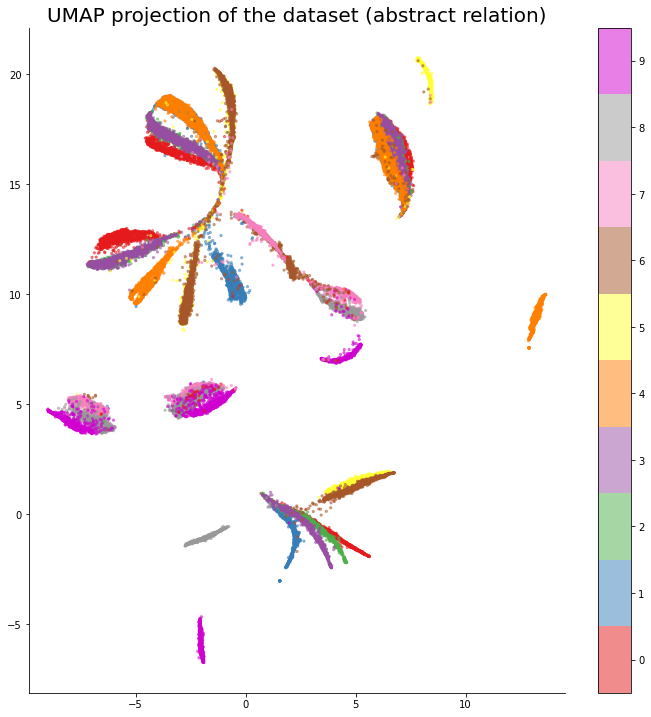

In [46]:
rela_test = (y_test % 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=rela_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
# cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);

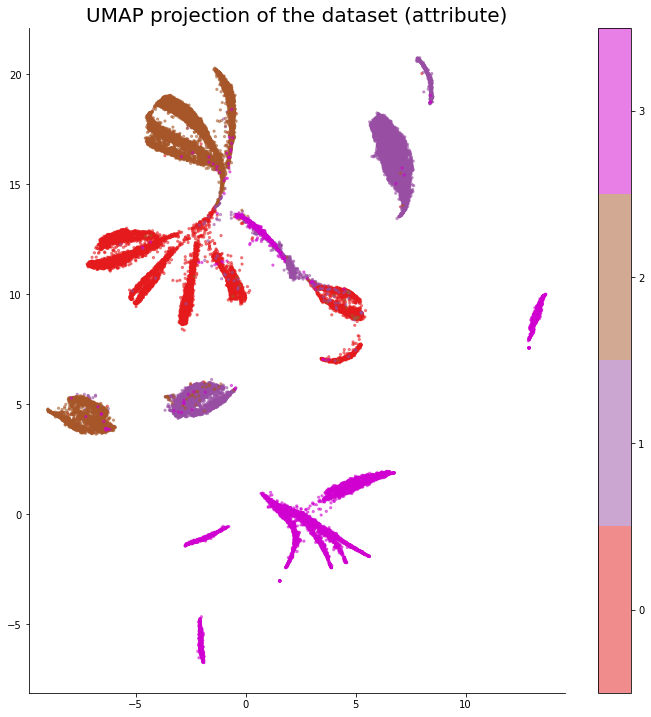

In [50]:
rela_test = (y_test // 10) 
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=rela_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(5)-0.5)
cb.set_ticks(np.arange(4))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
# cb.set_ticklabels([row_table[i] for i in range(10)])
plt.title('UMAP projection of the dataset (attribute)', fontsize=20);

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
layername = "blocks11"#"dec.1x1_in1"#"dec.3x3_up";#"dec.1x1_in1" # "enc.1x1_down"
# Compute the cosine similarity matrix
featmatr = feature_avg_col_test[layername].flatten(start_dim=1)#.squeeze()
feat_shape = feature_avg_col_test[layername].shape[1:]
feat_mean = featmatr.mean(dim=0)
feat_cent = featmatr - feat_mean[None, :]
featmat_sparse = feat_cent[::10,:]
cosine_sim_matrix = cosine_similarity(featmat_sparse)
# print(cosine_sim_matrix)
n = cosine_sim_matrix.shape[0]
reshaped = cosine_sim_matrix.reshape(40, n//40, 40, n//40)
coarse_grained_matrix = reshaped.mean(axis=(1, 3))

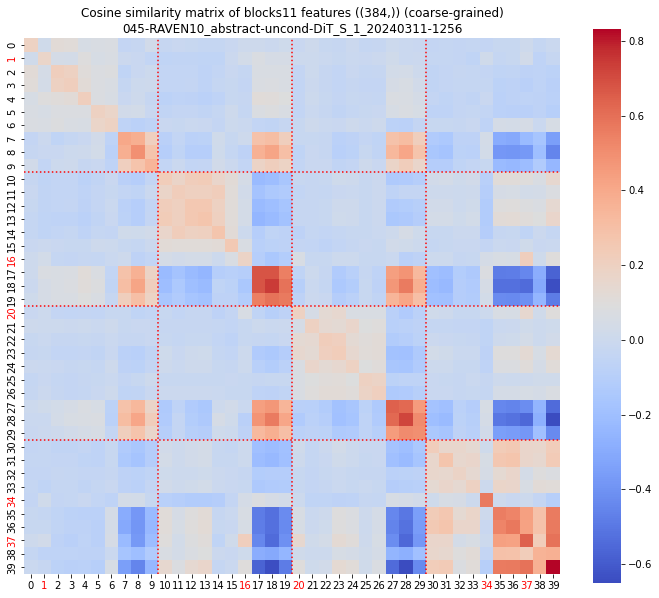

In [57]:
heldout_ids = heldout_rules
plt.figure(figsize=(12,10))
sns.heatmap(coarse_grained_matrix, annot=False, cmap='coolwarm', 
            xticklabels=True, yticklabels=True)
for sep in [10,20,30]:
    plt.axhline(sep, color="r", linestyle=":")
    plt.axvline(sep, color="r", linestyle=":")
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for i, xtick in enumerate(xticks):
    if i in heldout_ids:  # Change color of every 10th xtick label
        xtick.set_color('red')
for i, ytick in enumerate(yticks):
    if i in heldout_ids:  # Change color of every 10th ytick label
        ytick.set_color('red')
plt.axis("image")
plt.title(f"Cosine similarity matrix of {layername} features ({tuple(feat_shape)}) (coarse-grained)\n{expname}") #  (red=held-out)
# saveallforms(fig_expdir, f"cosine_sim_{layername}_t{t_str}",)
plt.show()

### Overall Modulation layer? (not working..)

In [19]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in (2,5,8,11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i].adaLN_modulation, target_name=f"blocks.adaLN_modulation{i}")
# fetcher.cleanup()
feature_col = defaultdict(list)
with th.no_grad():
    model_DiT(torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), y=torch.zeros(2, dtype=torch.int, device="cuda"))
for key, activations in fetcher.activations.items():
    feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)

blocks.adaLN_modulation2 torch.Size([2, 2304])
blocks.adaLN_modulation5 torch.Size([2, 2304])
blocks.adaLN_modulation8 torch.Size([2, 2304])
blocks.adaLN_modulation11 torch.Size([2, 2304])


In [22]:
# layerkey = "blocks.11"
fetcher = featureFetcher_module()
for i in [0,2,5,8,11]: #range(12):
    fetcher.record_module(model.blocks[i].adaLN_modulation, target_name=f"blocks.adaLN_modulation{i}")
    
train_loader = DataLoader(train_dataset, batch_size=1524, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1524, shuffle=False)
t_scalar = 0.1
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)


feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:32<00:00,  2.42it/s]


blocks.adaLN_modulation0 torch.Size([120000, 2304])
blocks.adaLN_modulation2 torch.Size([120000, 2304])
blocks.adaLN_modulation5 torch.Size([120000, 2304])
blocks.adaLN_modulation8 torch.Size([120000, 2304])
blocks.adaLN_modulation11 torch.Size([120000, 2304])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.64it/s]


blocks.adaLN_modulation0 torch.Size([40000, 2304])
blocks.adaLN_modulation2 torch.Size([40000, 2304])
blocks.adaLN_modulation5 torch.Size([40000, 2304])
blocks.adaLN_modulation8 torch.Size([40000, 2304])
blocks.adaLN_modulation11 torch.Size([40000, 2304])


In [24]:
import time

In [25]:
PC_dim = 1024
noPCA = True
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in feature_col.keys():
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    t1 = time.time()
    if noPCA:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict


Epoch [1/5000], Loss: nan, Accuracy: 0.0250
Epoch [250/5000], Loss: nan, Accuracy: 0.0250
Epoch [500/5000], Loss: nan, Accuracy: 0.0250
Epoch [750/5000], Loss: nan, Accuracy: 0.0250
Epoch [1000/5000], Loss: nan, Accuracy: 0.0250
Test Accuracy: 0.0250
Epoch [1250/5000], Loss: nan, Accuracy: 0.0250


KeyboardInterrupt: 

In [29]:
featmat

tensor([[ 0.1629,  0.2847, -0.0008,  ...,  0.0006,  0.0022, -0.0093],
        [ 0.1629,  0.2847, -0.0008,  ...,  0.0006,  0.0022, -0.0093],
        [ 0.1629,  0.2847, -0.0008,  ...,  0.0006,  0.0022, -0.0093],
        ...,
        [ 0.1629,  0.2847, -0.0008,  ...,  0.0006,  0.0022, -0.0093],
        [ 0.1629,  0.2847, -0.0008,  ...,  0.0006,  0.0022, -0.0093],
        [ 0.1629,  0.2847, -0.0008,  ...,  0.0006,  0.0022, -0.0093]])

In [28]:
feat_PCA_std

tensor([1.4379e-09, 2.8758e-09, 8.9870e-10,  ..., 1.2357e-10, 1.1234e-10,
        7.1896e-10], device='cuda:0')

### MLP hidden layer

In [31]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in (2,5,8,11):#range(len(model.blocks)):
    fetcher.record_module(model.blocks[i].mlp.act, target_name=f"blocks{i}.mlp.act")
# fetcher.cleanup()
feature_col = defaultdict(list)
model(torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), y=torch.zeros(2, dtype=torch.int, device="cuda"))
for key, activations in fetcher.activations.items():
    feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)

blocks2.mlp.act torch.Size([2, 81, 1536])
blocks5.mlp.act torch.Size([2, 81, 1536])
blocks8.mlp.act torch.Size([2, 81, 1536])
blocks11.mlp.act torch.Size([2, 81, 1536])


In [32]:
fetcher.cleanup()

FeatureFetcher hooks all freed


In [34]:
# layerkey = "blocks.11"
fetcher = featureFetcher_module()
for i in (11,):#range(len(model.blocks)):
    fetcher.record_module(model.blocks[i].mlp.act, target_name=f"blocks{i}.mlp.act")
    
train_loader = DataLoader(train_dataset, batch_size=1524, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1524, shuffle=False)
t_scalar = 0.1
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)


feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)

FeatureFetcher hooks all freed


 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 59/79 [00:34<00:17,  1.17it/s]

: 

: 

: 

In [ ]:
PC_dim = 1024
noPCA = True
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in feature_col.keys():
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    t1 = time.time()
    if noPCA:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict


Epoch [1/5000], Loss: nan, Accuracy: 0.0250
Epoch [250/5000], Loss: nan, Accuracy: 0.0250
Epoch [500/5000], Loss: nan, Accuracy: 0.0250
Epoch [750/5000], Loss: nan, Accuracy: 0.0250
Epoch [1000/5000], Loss: nan, Accuracy: 0.0250
Test Accuracy: 0.0250
Epoch [1250/5000], Loss: nan, Accuracy: 0.0250


KeyboardInterrupt: 

### MLP output

In [18]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in (2,5,8,11):#range(len(model.blocks)):
    fetcher.record_module(model.blocks[i].mlp, target_name=f"blocks{i}.mlp")
# fetcher.cleanup()
feature_col = defaultdict(list)
model(torch.randn(2, 3, 9, 9).to("cuda"), torch.rand(2,).to("cuda"), y=torch.zeros(2, dtype=torch.int, device="cuda"))
for key, activations in fetcher.activations.items():
    feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)

blocks2.mlp torch.Size([2, 81, 384])
blocks5.mlp torch.Size([2, 81, 384])
blocks8.mlp torch.Size([2, 81, 384])
blocks11.mlp torch.Size([2, 81, 384])


In [23]:
fetcher.cleanup()

FeatureFetcher hooks all freed


In [19]:
# layerkey = "blocks.11"
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model.blocks[i].mlp, target_name=f"blocks{i}.mlp")
train_loader = DataLoader(train_dataset, batch_size=1524, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1524, shuffle=False)
t_scalar = 100
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)


feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.54it/s]


blocks5.mlp torch.Size([120000, 81, 384])
blocks11.mlp torch.Size([120000, 81, 384])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:17<00:00,  1.59it/s]


blocks5.mlp torch.Size([40000, 81, 384])
blocks11.mlp torch.Size([40000, 81, 384])


In [21]:
PC_dim = 1024
noPCA = False
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in feature_col.keys():
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    t1 = time.time()
    if noPCA:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    clsfr, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = clsfr
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict


torch.Size([120000, 1024]) torch.Size([1024]) torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8438, Accuracy: 0.0262
Epoch [250/5000], Loss: 0.4047, Accuracy: 0.8787
Epoch [500/5000], Loss: 0.3370, Accuracy: 0.8936
Epoch [750/5000], Loss: 0.3082, Accuracy: 0.9001
Epoch [1000/5000], Loss: 0.2914, Accuracy: 0.9039
Test Accuracy: 0.8028
Epoch [1250/5000], Loss: 0.2801, Accuracy: 0.9069
Epoch [1500/5000], Loss: 0.2718, Accuracy: 0.9089
Epoch [1750/5000], Loss: 0.2654, Accuracy: 0.9107
Epoch [2000/5000], Loss: 0.2603, Accuracy: 0.9118
Test Accuracy: 0.8015
Epoch [2250/5000], Loss: 0.2560, Accuracy: 0.9129
Epoch [2500/5000], Loss: 0.2524, Accuracy: 0.9142
Epoch [2750/5000], Loss: 0.2492, Accuracy: 0.9152
Epoch [3000/5000], Loss: 0.2465, Accuracy: 0.9160
Test Accuracy: 0.7970
Epoch [3250/5000], Loss: 0.2441, Accuracy: 0.9168
Epoch [3500/5000], Loss: 0.2420, Accuracy: 0.9174
Epoch [3750/5000], Loss: 0.2400, Accuracy: 0.9180
Epoch [4000/5000], Loss: 0.2383, Accuracy: 0.9185
Test Accuracy: 0.7

### Attention output?

In [23]:
for i in range(len(model.blocks)):
    print(model.blocks[i].attn.fused_attn)
    # set it to be False
    model.blocks[i].attn.fused_attn = False

True
True
True
True
True
True
True
True
True
True
True
True


In [24]:
fetcher = featureFetcher_module()
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
for i in range(len(model.blocks)):
    fetcher.record_module(model.blocks[i].attn.attn_drop, target_name=f"blocks.attnmap{i}")
fetcher.cleanup()
# note this is critical, if the model use fused_attn, it's more efficient, but will skip the dropout layer, so not hookable. 


FeatureFetcher hooks all freed


In [26]:
# layerkey = "blocks.11"
fetcher = featureFetcher_module()
for i in [5,11]: #range(12):
    fetcher.record_module(model.blocks[i].attn.attn_drop, target_name=f"blocks.attnmap{i}")
    
train_loader = DataLoader(train_dataset, batch_size=1524, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1524, shuffle=False)
t_scalar = 0.1
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)

  0%|                                                                                                                            | 0/79 [00:00<?, ?it/s]

FeatureFetcher hooks all freed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:41<00:00,  1.92it/s]


blocks.attnmap5 torch.Size([120000, 6, 81, 81])
blocks.attnmap11 torch.Size([120000, 6, 81, 81])


In [67]:
feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:13<00:00,  1.98it/s]


blocks.attnmap5 torch.Size([40000, 6, 81, 81])
blocks.attnmap11 torch.Size([40000, 6, 81, 81])


### Exploratory analysis of visual transformer attention pattern

Text(0.5, 0.98, 'Head Attention Map for sample 300 of class 10 in layer 5')

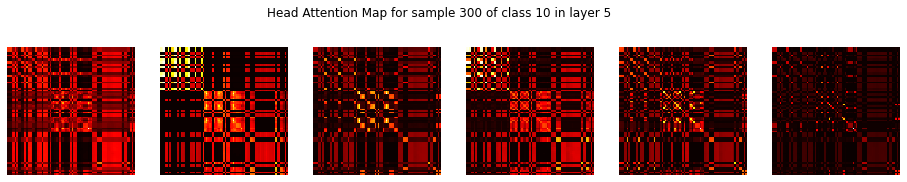

In [48]:
# feature_col['blocks.attnmap5'][0][0]
class_id = 10
sample_id = 300
layer_id = 11
idx = 3000 * class_id + sample_id
figh, axs = plt.subplots(1, 6, figsize=(16, 3))
for ihead in range(6):
    axs[ihead].imshow(feature_col[f'blocks.attnmap{layer_id}'][idx][ihead].cpu().numpy(), cmap="hot", interpolation="nearest")
    axs[ihead].axis("off")
plt.suptitle(f"Head Attention Map for sample {sample_id} of class {class_id} in layer 5")

In [57]:
X_train[idx].device

device(type='cpu')

In [58]:
dataset_Xmean.device

device(type='cuda', index=0)

In [61]:
X_train[idx]

tensor([[[-1, -1, -1,  5,  5, -1,  5, -1,  5],
         [ 5, -1, -1,  5,  5,  5,  5, -1,  5],
         [-1,  5, -1, -1, -1,  5,  5,  5,  5],
         [ 5,  5,  5,  5,  5,  5,  5,  5,  5],
         [ 5,  5,  5,  5, -1, -1, -1,  5,  5],
         [ 5,  5,  5,  5, -1, -1,  5, -1, -1],
         [ 6,  6,  6,  6, -1,  6, -1,  6,  6],
         [ 6,  6, -1,  6,  6,  6,  6,  6,  6],
         [-1,  6,  6, -1, -1, -1,  6,  6,  6]],

        [[-1, -1, -1,  1,  1, -1,  0, -1,  0],
         [ 6, -1, -1,  1,  1,  1,  0, -1,  0],
         [-1,  6, -1, -1, -1,  1,  0,  0,  0],
         [ 4,  4,  4,  5,  5,  5,  0,  0,  0],
         [ 4,  4,  4,  5, -1, -1, -1,  0,  0],
         [ 4,  4,  4,  5, -1, -1,  0, -1, -1],
         [ 8,  2,  7,  3, -1,  5, -1,  6,  7],
         [ 4,  3, -1,  2,  1,  7,  4,  3,  0],
         [-1,  1,  6, -1, -1, -1,  2,  5,  1]],

        [[-1, -1, -1,  4,  4, -1,  4, -1,  4],
         [ 5, -1, -1,  4,  4,  4,  4, -1,  4],
         [-1,  5, -1, -1, -1,  4,  4,  4,  4],
         

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


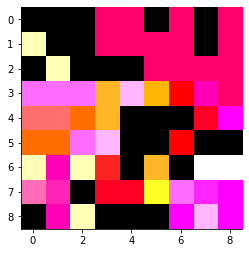

In [60]:
plt.imshow(((X_train[idx]-dataset_Xmean[0].cpu())/dataset_Xstd[0].cpu()).float().numpy().transpose(1,2,0))

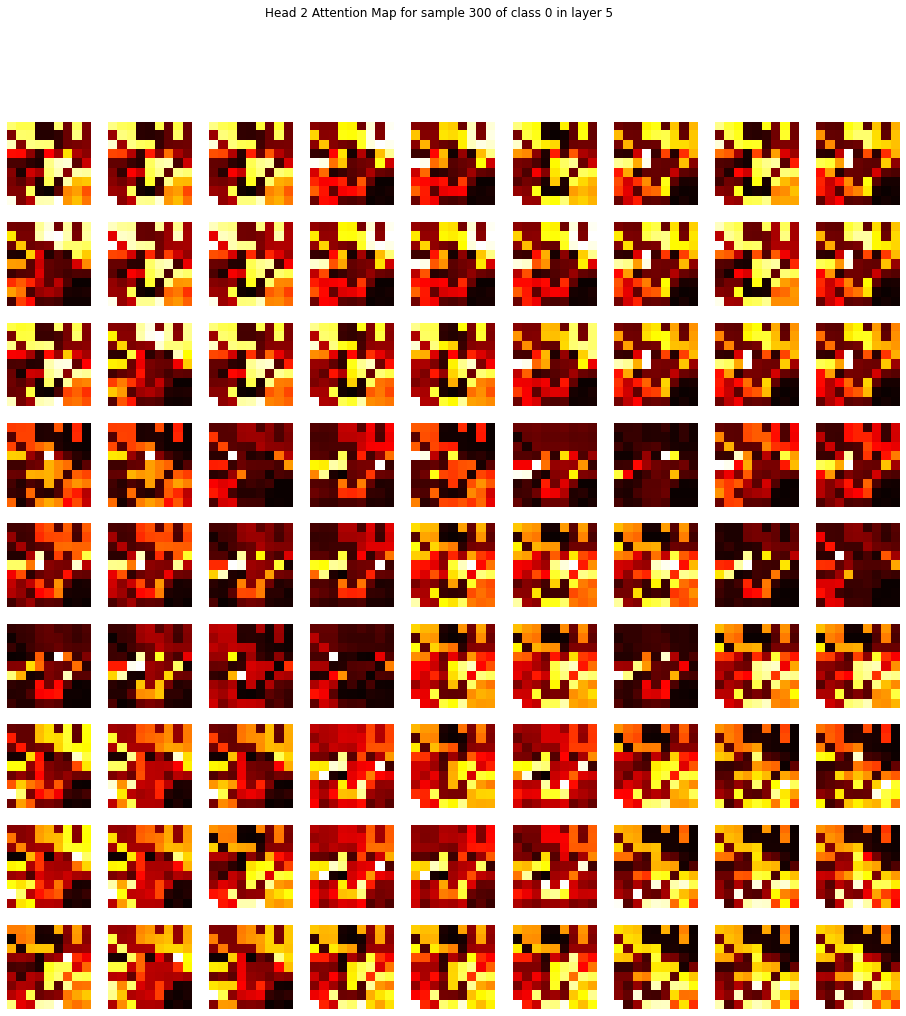

In [65]:
class_id = 0
sample_id = 300
layer_id = 5
idx = 3000 * class_id + sample_id
figh, axs = plt.subplots(9, 9, figsize=(16, 16))
axs = axs.flatten()
# for ihead in range(6):
ihead = 2
attnmap = feature_col[f'blocks.attnmap{layer_id}'][idx][ihead].cpu().numpy()
for query_id in range(81):
    axs[query_id].imshow(attnmap[query_id, :].reshape(9, 9), cmap="hot", interpolation="nearest")
    axs[query_id].axis("off")
plt.suptitle(f"Head {ihead} Attention Map for sample {sample_id} of class {class_id} in layer 5")
plt.show()

### Train classifier

In [68]:
# feature_col["blocks.11"].view(len(train_dataset),-1)
model = fit_SGD_linear_classifier(feature_col["blocks.attnmap5"].view(len(train_dataset),-1), y_train,
                                  feature_col_test["blocks.attnmap5"].view(len(test_dataset),-1), y_test,
                                  num_classes=40, batch_size=1024, num_epochs=100, print_every=10,
                                  learning_rate = 0.0001)

Epoch [1/100], Loss: 3.6238, Accuracy: 0.0784
Epoch [100/100], Loss: 1.8461, Accuracy: 0.5992
Test Accuracy: 0.5278
Test Accuracy: 0.5278


In [69]:
# feature_col["blocks.11"].view(len(train_dataset),-1)
model = fit_SGD_linear_classifier(feature_col["blocks.attnmap11"].view(len(train_dataset),-1), y_train,
                                  feature_col_test["blocks.attnmap11"].view(len(test_dataset),-1), y_test,
                                  num_classes=40, batch_size=1024, num_epochs=100, print_every=10,
                                  learning_rate = 0.0001)

Epoch [1/100], Loss: 3.4838, Accuracy: 0.1960
Epoch [10/100], Loss: 2.4127, Accuracy: 0.5318
Epoch [20/100], Loss: 1.9008, Accuracy: 0.6215
Epoch [30/100], Loss: 1.6050, Accuracy: 0.6731
Epoch [40/100], Loss: 1.4192, Accuracy: 0.7099
Epoch [50/100], Loss: 1.2996, Accuracy: 0.7383
Epoch [60/100], Loss: 1.1593, Accuracy: 0.7618
Epoch [70/100], Loss: 1.0620, Accuracy: 0.7812
Epoch [80/100], Loss: 1.0373, Accuracy: 0.7977
Epoch [90/100], Loss: 0.9363, Accuracy: 0.8128
Epoch [100/100], Loss: 0.8537, Accuracy: 0.8254
Test Accuracy: 0.6649
Test Accuracy: 0.6649


In [70]:
list(feature_col)

['blocks.attnmap5', 'blocks.attnmap11']

In [71]:
import time

In [72]:
PC_dim = 1024

model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in ['blocks.attnmap5', 'blocks.attnmap11']:
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
    print(U.shape, S.shape, V.shape)
    del U, S
    torch.cuda.empty_cache()
    t1 = time.time()
    feat_PCA = (featmat - featmean[None,]).cuda() @ V
    feat_PCA_std = feat_PCA.std(dim=0)
    feat_PCA = feat_PCA / feat_PCA_std
    feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
    feat_PCA_test = feat_PCA_test / feat_PCA_std
    torch.cuda.empty_cache()
    V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict


: 

: 

: 

## Scratch space

In [ ]:
PC_dim = 1024
noPCA = False
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in feature_col.keys():
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    t1 = time.time()
    if noPCA:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict


torch.Size([120000, 1024]) torch.Size([1024]) torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8490, Accuracy: 0.0251
Epoch [250/5000], Loss: 1.1821, Accuracy: 0.6436
Epoch [500/5000], Loss: 1.0487, Accuracy: 0.6751
Epoch [750/5000], Loss: 0.9914, Accuracy: 0.6885
Epoch [1000/5000], Loss: 0.9581, Accuracy: 0.6975
Test Accuracy: 0.5821
Epoch [1250/5000], Loss: 0.9360, Accuracy: 0.7035
Epoch [1500/5000], Loss: 0.9201, Accuracy: 0.7074
Epoch [1750/5000], Loss: 0.9082, Accuracy: 0.7100
Epoch [2000/5000], Loss: 0.8990, Accuracy: 0.7121
Test Accuracy: 0.5962
Epoch [2250/5000], Loss: 0.8916, Accuracy: 0.7138
Epoch [2500/5000], Loss: 0.8855, Accuracy: 0.7157
Epoch [2750/5000], Loss: 0.8805, Accuracy: 0.7167
Epoch [3000/5000], Loss: 0.8763, Accuracy: 0.7176
Test Accuracy: 0.6007
Epoch [3250/5000], Loss: 0.8728, Accuracy: 0.7182
Epoch [3500/5000], Loss: 0.8697, Accuracy: 0.7189
Epoch [3750/5000], Loss: 0.8671, Accuracy: 0.7194
Epoch [4000/5000], Loss: 0.8649, Accuracy: 0.7200
Test Accuracy: 0.6

In [ ]:
t_scalar = 50
# layerkey = "blocks.11"
fetcher = featureFetcher_module()
for i in (5,11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model_DiT.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)


feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model_DiT.forward(X_batch_norm, t_vec, **model_kwargs)
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)

FeatureFetcher hooks all freed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:37<00:00,  1.59it/s]


blocks5 torch.Size([120000, 81, 384])
blocks11 torch.Size([120000, 81, 384])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]


blocks5 torch.Size([40000, 81, 384])
blocks11 torch.Size([40000, 81, 384])


In [ ]:
th.cuda.empty_cache()

In [ ]:
PC_dim = 1024
noPCA = False
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in feature_col.keys():
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    t1 = time.time()
    if noPCA:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict


torch.Size([120000, 1024]) torch.Size([1024]) torch.Size([31104, 1024])
Epoch [1/5000], Loss: 3.8343, Accuracy: 0.0265
Epoch [250/5000], Loss: 0.3640, Accuracy: 0.9008
Epoch [500/5000], Loss: 0.2743, Accuracy: 0.9218
Epoch [750/5000], Loss: 0.2355, Accuracy: 0.9314
Epoch [1000/5000], Loss: 0.2124, Accuracy: 0.9365
Test Accuracy: 0.8400
Epoch [1250/5000], Loss: 0.1966, Accuracy: 0.9402
Epoch [1500/5000], Loss: 0.1847, Accuracy: 0.9430
Epoch [1750/5000], Loss: 0.1753, Accuracy: 0.9455
Epoch [2000/5000], Loss: 0.1676, Accuracy: 0.9475
Test Accuracy: 0.8418
Epoch [2250/5000], Loss: 0.1610, Accuracy: 0.9493
Epoch [2500/5000], Loss: 0.1554, Accuracy: 0.9508
Epoch [2750/5000], Loss: 0.1504, Accuracy: 0.9521
Epoch [3000/5000], Loss: 0.1459, Accuracy: 0.9534
Test Accuracy: 0.8404
Epoch [3250/5000], Loss: 0.1419, Accuracy: 0.9544
Epoch [3500/5000], Loss: 0.1382, Accuracy: 0.9554
Epoch [3750/5000], Loss: 0.1348, Accuracy: 0.9564
Epoch [4000/5000], Loss: 0.1316, Accuracy: 0.9575
Test Accuracy: 0.8

In [ ]:
PC_dim = 1024
noPCA = False
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in feature_col.keys():
    t0 = time.time()
    featmat = feature_col[layerkey].view(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].view(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    t1 = time.time()
    if noPCA:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=0.005)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    PC_proj_col[layerkey] = (V, featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict
